In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, save_model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling3D, Flatten, Dense, MaxPool3D
from tensorflow.keras.layers import Reshape, UpSampling3D, Input, TimeDistributed
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Dissertation/Unsupervised Learning of Video Representations/Dataset/"

In [4]:
no_of_frames = 250
frame_height = 16
frame_width = 16
channels = 3

In [5]:
# reading the video frame by frame
def get_frames(video_path):
  frame_list = []
  count = 1

  # capturing the video using opencv
  video = cv2.VideoCapture(video_path)

  # looping till the no_of_frames are extracted
  while count <= no_of_frames:

    # read each frame from a video
    success, frame = video.read()

    # on success of reading a frame resize and normalize the frame and append to the list
    if success:
      frame = cv2.resize(frame, (frame_height, frame_width))
      frame = frame.astype('float32') / 255.0
      frame_list.append(frame)
      count+=1
    else:
      break
      
  return frame_list

In [6]:
# Preparing the dataset of videos with each of 250 frames of 16x16x3 size
X_train = []
X_test = []
y_train = []
y_test = []
str_class = 'dance'

# listing the directories under dataset_path
subdirs = os.listdir(dataset_path) # includes train and test folders

for folders in subdirs:
  # listing the directories under train and test folders
  train_test = os.listdir(os.path.join(dataset_path, folders)) # includes dance and fight folders

  for train_test_data in train_test:
    # listing the files under dance and fight folders
    video_files = os.listdir(os.path.join(os.path.join(dataset_path, folders), train_test_data))

    for vid in video_files:
      # iterating through each video file and getting the frame list
      frames =  get_frames(os.path.join(os.path.join(os.path.join(dataset_path, folders), train_test_data), vid))
      #print(vid, "  --  ", np.asarray(frames).shape)

      if len(frames) == no_of_frames:
        # check if the folder is train then add the data to the train list
        if folders.lower() == 'train':
          X_train.append(frames)

          # preparing the target variable based on dance and fight category - dance : 0 , fight : 1
          if train_test_data.lower() == str_class.lower():
            y_train.append(0)
          else:
            y_train.append(1)
        # check if the folder is test then add the data to the test list
        elif folders.lower() == 'test':
          X_test.append(frames)

          if train_test_data.lower() == str_class.lower():
            y_test.append(0)
          else:
            y_test.append(1)

In [7]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_train.shape, X_test.shape

((48, 250, 16, 16, 3), (12, 250, 16, 16, 3))

In [8]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train.shape, y_test.shape

((48,), (12,))

In [9]:
print("y_train", y_train , "\n")
print("y_test", y_test)

y_train [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] 

y_test [1 1 1 1 1 1 0 0 0 0 0 0]


In [11]:
autoencoder = Sequential()

# Encoder
autoencoder.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1, input_shape=(no_of_frames, frame_width, frame_height, channels)))
autoencoder.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"))
autoencoder.add(BatchNormalization())
           
autoencoder.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"))
autoencoder.add(BatchNormalization())
           
autoencoder.add(Flatten())

# Decoder
flatten_output_shape = autoencoder.layers[5].output.shape
reshape_dim = (flatten_output_shape[1], flatten_output_shape[2], flatten_output_shape[3], flatten_output_shape[4])

autoencoder.add(Reshape(reshape_dim))

autoencoder.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(UpSampling3D(size=(1, 2, 2)))

autoencoder.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(UpSampling3D(size=(1, 2, 2)))

autoencoder.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_5 (ConvLSTM2D)  (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 250, 4, 4, 16)     64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)            

## Hyperparameter Tuning

In [12]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Dissertation/Unsupervised Learning of Video Representations/saved_model/"

#### Learning rate - 0.001

In [131]:
# reading the model from the json file
with open(saved_model_path + 'LR-0.001/RMSprop_model_0.001lr.json', 'r') as json_file:
  rmsprop_001lr = json_file.read()

In [132]:
rmsprop_model_001lr = tf.keras.models.model_from_json(rmsprop_001lr)
rmsprop_model_001lr.load_weights(saved_model_path + 'LR-0.001/weights_rmsprop_0.001lr.hdf5')
rmsprop_model_001lr.compile(loss='mse', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [133]:
# creating an encoder 
encoder_rmsprop_001lr = Model(inputs = rmsprop_model_001lr.input, outputs = rmsprop_model_001lr.layers[6].output)
encoder_rmsprop_001lr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64  

##### Train data

In [134]:
# encoding the Test videos
encoded_train_video_rmsprop_001lr = encoder_rmsprop_001lr.predict(X_train)
encoded_train_video_rmsprop_001lr.shape

(48, 64000)

In [135]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_001lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_train_001lr = kmeans_rmsprop_001lr.fit_predict(encoded_train_video_rmsprop_001lr)
y_pred_kmeans_rmsprop_train_001lr

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0], dtype=int32)

In [136]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_train_001lr = accuracy_score(y_train, y_pred_kmeans_rmsprop_train_001lr)
rmsprop_clustering_accuracy_train_001lr

0.4791666666666667

In [137]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_rmsprop_train_001lr)
cm

array([[12, 12],
       [13, 11]])

##### Test data

In [138]:
# encoding the Test videos
encoded_test_video_rmsprop_001lr = encoder_rmsprop_001lr.predict(X_test)
encoded_test_video_rmsprop_001lr.shape

(12, 64000)

In [139]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_001lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_test_001lr = kmeans_rmsprop_001lr.fit_predict(encoded_test_video_rmsprop_001lr)
y_pred_kmeans_rmsprop_test_001lr

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [140]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_test_001lr = accuracy_score(y_test, y_pred_kmeans_rmsprop_test_001lr)
rmsprop_clustering_accuracy_test_001lr

0.5

In [141]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_rmsprop_test_001lr)
cm

array([[4, 2],
       [4, 2]])

#### Learning rate - 0.01

In [142]:
# reading the model from the json file
with open(saved_model_path + 'LR-0.01/RMSprop_model_0.01lr.json', 'r') as json_file:
  rmsprop_01lr = json_file.read()

In [143]:
rmsprop_model_01lr = tf.keras.models.model_from_json(rmsprop_01lr)
rmsprop_model_01lr.load_weights(saved_model_path + 'LR-0.01/weights_rmsprop_0.01lr.hdf5')
rmsprop_model_01lr.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

In [144]:
# creating an encoder 
encoder_rmsprop_01lr = Model(inputs = rmsprop_model_01lr.input, outputs = rmsprop_model_01lr.layers[6].output)
encoder_rmsprop_01lr.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64  

##### Train data

In [145]:
# encoding the Test videos
encoded_train_video_rmsprop_01lr = encoder_adagrad_01lr.predict(X_train)
encoded_train_video_rmsprop_01lr.shape

(48, 64000)

In [148]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_01lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_train_01lr = kmeans_rmsprop_01lr.fit_predict(encoded_train_video_rmsprop_01lr)
y_pred_kmeans_rmsprop_train_01lr

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0], dtype=int32)

In [149]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_train_01lr = accuracy_score(y_train, y_pred_kmeans_rmsprop_train_01lr)
rmsprop_clustering_accuracy_train_01lr

0.5416666666666666

In [150]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_rmsprop_train_01lr)
cm

array([[14, 10],
       [12, 12]])

##### Test data

In [151]:
# encoding the Test videos
encoded_test_video_rmsprop_01lr = encoder_rmsprop_01lr.predict(X_test)
encoded_test_video_rmsprop_01lr.shape

(12, 64000)

In [154]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_01lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_test_01lr = kmeans_rmsprop_01lr.fit_predict(encoded_test_video_rmsprop_01lr)
y_pred_kmeans_rmsprop_test_01lr

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [155]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_test_01lr = accuracy_score(y_test, y_pred_kmeans_rmsprop_test_01lr)
rmsprop_clustering_accuracy_test_01lr

0.5833333333333334

In [156]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_rmsprop_test_01lr)
cm

array([[5, 1],
       [4, 2]])

#### Learning rate - 0.5

In [157]:
# reading the model from the json file
with open(saved_model_path + 'LR-0.05/RMSprop_model_0.05lr.json', 'r') as json_file:
  rmsprop_05lr = json_file.read()

In [158]:
rmsprop_model_05lr = tf.keras.models.model_from_json(rmsprop_05lr)
rmsprop_model_05lr.load_weights(saved_model_path + 'LR-0.05/weights_adagrad_0.05lr.hdf5')
rmsprop_model_05lr.compile(loss='mse', optimizer=RMSprop(learning_rate=0.05), metrics=['accuracy'])

In [159]:
# creating an encoder 
encoder_rmsprop_05lr = Model(inputs = rmsprop_model_05lr.input, outputs = rmsprop_model_05lr.layers[6].output)
encoder_rmsprop_05lr.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64  

##### Train data

In [160]:
# encoding the Test videos
encoded_train_video_rmsprop_05lr = encoder_rmsprop_05lr.predict(X_train)
encoded_train_video_rmsprop_05lr.shape

(48, 64000)

In [161]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_05lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_train_05lr = kmeans_rmsprop_05lr.fit_predict(encoded_train_video_rmsprop_05lr)
y_pred_kmeans_rmsprop_train_05lr

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1], dtype=int32)

In [162]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_train_05lr = accuracy_score(y_train, y_pred_kmeans_rmsprop_train_05lr)
rmsprop_clustering_accuracy_train_05lr

0.5208333333333334

In [163]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_rmsprop_train_05lr)
cm

array([[12, 12],
       [11, 13]])

##### Test data

In [164]:
# encoding the Test videos
encoded_test_video_rmsprop_05lr = encoder_rmsprop_05lr.predict(X_test)
encoded_test_video_rmsprop_05lr.shape

(12, 64000)

In [173]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop_05lr = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_test_05lr = kmeans_rmsprop_05lr.fit_predict(encoded_test_video_rmsprop_05lr)
y_pred_kmeans_rmsprop_test_05lr

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

In [174]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_test_05lr = accuracy_score(y_test, y_pred_kmeans_rmsprop_test_05lr)
rmsprop_clustering_accuracy_test_05lr

0.5

In [175]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_rmsprop_test_05lr)
cm

array([[2, 4],
       [2, 4]])

#### Train ROC

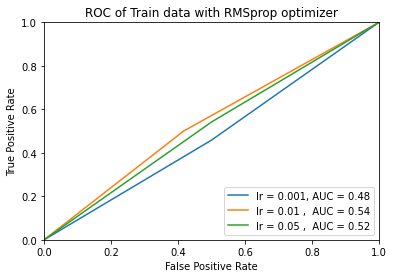

In [178]:
import sklearn.metrics as metrics

fpr_train_001, tpr_train_001, threshold_train_001 = metrics.roc_curve(y_train, y_pred_kmeans_rmsprop_train_001lr)
roc_auc_train_001 = metrics.auc(fpr_train_001, tpr_train_001)

fpr_train_01, tpr_train_01, threshold_train_01 = metrics.roc_curve(y_train, y_pred_kmeans_rmsprop_train_01lr)
roc_auc_train_01 = metrics.auc(fpr_train_01, tpr_train_01)

fpr_train_05, tpr_train_05, threshold_train_05 = metrics.roc_curve(y_train, y_pred_kmeans_rmsprop_train_05lr)
roc_auc_train_05 = metrics.auc(fpr_train_05, tpr_train_05)

plt.title('ROC of Train data with RMSprop optimizer')
plt.plot(fpr_train_001, tpr_train_001, label = 'lr = 0.001, AUC = %0.2f' % roc_auc_train_001)
plt.plot(fpr_train_01, tpr_train_01, label = 'lr = 0.01 ,  AUC = %0.2f' % roc_auc_train_01)
plt.plot(fpr_train_05, tpr_train_05, label = 'lr = 0.05 ,  AUC = %0.2f' % roc_auc_train_05)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Test ROC

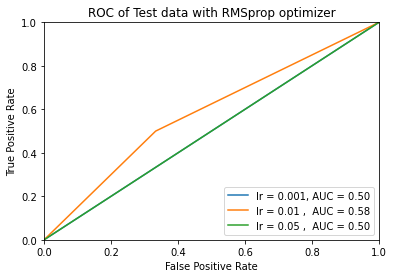

In [179]:
import sklearn.metrics as metrics

fpr_test_001, tpr_test_001, threshold_test_001 = metrics.roc_curve(y_test, y_pred_kmeans_adagrad_test_001lr)
roc_auc_test_001 = metrics.auc(fpr_test_001, tpr_test_001)

fpr_test_01, tpr_test_01, threshold_test_01 = metrics.roc_curve(y_test, y_pred_kmeans_adagrad_test_01lr)
roc_auc_test_01 = metrics.auc(fpr_test_01, tpr_test_01)

fpr_test_05, tpr_test_05, threshold_test_05 = metrics.roc_curve(y_test, y_pred_kmeans_adagrad_test_05lr)
roc_auc_test_05 = metrics.auc(fpr_test_05, tpr_test_05)

plt.title('ROC of Test data with RMSprop optimizer')
plt.plot(fpr_test_001, tpr_test_001, label = 'lr = 0.001, AUC = %0.2f' % roc_auc_test_001)
plt.plot(fpr_test_01, tpr_test_01, label = 'lr = 0.01 ,  AUC = %0.2f' % roc_auc_test_01)
plt.plot(fpr_test_05, tpr_test_05, label = 'lr = 0.05 ,  AUC = %0.2f' % roc_auc_test_05)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()